## 神经概率语言模型 (Neural Probabilistic Language Model)

#### 1. 项目简介

本项目实现了Bengio等人在2003年提出的经典神经概率语言模型(NPLM)也叫神经网络语言模型。
该模型同时学习：
1. 每个词的分布式表示（词嵌入）
2. 词序列的概率分布函数

**主要特点：**
- 解决传统one-hot表示的维度灾难问题
- 学习词的分布式表示，捕获语义相似性
- 通过神经网络建模条件概率P(word|context)

**数据集:** 使用包含32,000个名字的文本文件作为语料库

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 设置随机种子确保结果可复现
torch.manual_seed(1337)
random.seed(1337)

In [140]:
# 读取数据
with open('names.txt', 'r', encoding='utf-8') as f:
    words = f.read().splitlines()

print(f"数据集大小: {len(words)}")
print(f"前10个名字: {words[:10]}")

数据集大小: 32033
前10个名字: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


#### 2. 数据预处理

构建字符级别的词汇表，并创建字符到索引的映射关系。
特殊符号'.'用于表示序列的开始和结束。

In [141]:
# 提取所有唯一字符并排序
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.')  # 添加特殊标记
vocab_size = len(chars)

print(f"字符集: {''.join(chars)}")
print(f"词汇表大小: {vocab_size}")

# 创建字符与索引的双向映射
stoi = {ch: i for i, ch in enumerate(chars)}  # string to index
itos = {i: ch for i, ch in enumerate(chars)}  # index to string

print(f"字符映射示例: {dict(list(stoi.items())[:10])}")

字符集: .abcdefghijklmnopqrstuvwxyz
词汇表大小: 27
字符映射示例: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9}


#### 3. 构建训练数据

对于NPLM，我们需要构建上下文-目标词对。
使用滑动窗口从每个单词中提取固定长度的上下文，然后按照固定步长进行滑动。

**示例：** 对于单词"emma"，上下文长度为3时：
- 上下文: ['.', '.', '.'] → 目标: 'e'
- 上下文: ['.', '.', 'e'] → 目标: 'm'
- 上下文: ['.', 'e', 'm'] → 目标: 'm'
- 上下文: ['e', 'm', 'm'] → 目标: 'a'
- 上下文: ['m', 'm', 'a'] → 目标: '.'

In [142]:
def build_dataset(words, block_size, stoi):
    """构建训练数据集"""
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size  # 用'.'的索引初始化上下文
        for ch in word + '.':  # 在单词末尾添加结束标记
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # 滑动窗口更新
    
    return torch.tensor(X), torch.tensor(Y)

# 超参数设置
BLOCK_SIZE = 3  # 上下文长度
EMBED_DIM = 10  # 嵌入维度
HIDDEN_DIM = 200  # 隐藏层大小

# 构建完整数据集
X, Y = build_dataset(words, BLOCK_SIZE, stoi)

print(f"训练样本数量: {X.shape[0]}")
print(f"输入张量形状: {X.shape}")
print(f"目标张量形状: {Y.shape}")

训练样本数量: 228146
输入张量形状: torch.Size([228146, 3])
目标张量形状: torch.Size([228146])


In [143]:
# 显示前10个训练样本
print("\n前10个训练样本:")
for i in range(10):
    context = ''.join(itos[ix] for ix in X[i].tolist())
    target = itos[Y[i].item()]
    print(f"上下文: [{context}] → 目标: {target}")


前10个训练样本:
上下文: [...] → 目标: e
上下文: [..e] → 目标: m
上下文: [.em] → 目标: m
上下文: [emm] → 目标: a
上下文: [mma] → 目标: .
上下文: [...] → 目标: o
上下文: [..o] → 目标: l
上下文: [.ol] → 目标: i
上下文: [oli] → 目标: v
上下文: [liv] → 目标: i


#### 4. 数据集划分

将数据按8:1:1的比例划分为训练集、验证集和测试集，
确保模型评估的科学性。

In [144]:
def split_dataset(words, train_ratio=0.8, val_ratio=0.1):
    """划分数据集"""
    random.shuffle(words)
    n1 = int(train_ratio * len(words))
    n2 = int((train_ratio + val_ratio) * len(words))
    
    return words[:n1], words[n1:n2], words[n2:]

# 划分数据
train_words, val_words, test_words = split_dataset(words)

print(f"训练集: {len(train_words)} 个单词")
print(f"验证集: {len(val_words)} 个单词") 
print(f"测试集: {len(test_words)} 个单词")

# 构建各数据集
X_train, Y_train = build_dataset(train_words, BLOCK_SIZE, stoi)
X_val, Y_val = build_dataset(val_words, BLOCK_SIZE, stoi)
X_test, Y_test = build_dataset(test_words, BLOCK_SIZE, stoi)

print(f"\n训练样本: {X_train.shape[0]}")
print(f"验证样本: {X_val.shape[0]}")
print(f"测试样本: {X_test.shape[0]}")

训练集: 25626 个单词
验证集: 3203 个单词
测试集: 3204 个单词

训练样本: 182552
验证样本: 22737
测试样本: 22857


#### 5. 神经概率语言模型定义

NPLM的核心架构包括：
1. **嵌入层(Embedding Layer)**: 将离散字符索引映射到连续向量空间
2. **隐藏层(Hidden Layer)**: 使用tanh激活函数的全连接层
3. **输出层(Output Layer)**: 输出词汇表大小的logits

**关键创新**: 嵌入层充当"查找表"，避免了one-hot向量的稀疏性问题

In [145]:
class NPLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_size, hidden_dim):
        super().__init__()
        
        # 嵌入层：字符索引 → 嵌入向量
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # 隐藏层：拼接的嵌入向量 → 隐藏表示
        self.hidden = nn.Linear(context_size * embed_dim, hidden_dim)
        
        # 输出层：隐藏表示 → 词汇表概率分布
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        # 参数初始化
        self._init_weights()
    
    def _init_weights(self):
        """权重初始化"""
        for layer in [self.hidden, self.output]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        # x: (batch_size, context_size)
        
        # 1. 嵌入查找
        emb = self.embedding(x)  # (batch_size, context_size, embed_dim)
        
        # 2. 拼接嵌入向量
        emb_flat = emb.view(emb.shape[0], -1)  # (batch_size, context_size * embed_dim)
        
        # 3. 隐藏层处理
        hidden = torch.tanh(self.hidden(emb_flat))  # (batch_size, hidden_dim)
        
        # 4. 输出logits
        logits = self.output(hidden)  # (batch_size, vocab_size)
        
        return logits

# 实例化模型
model = NPLM(vocab_size, EMBED_DIM, BLOCK_SIZE, HIDDEN_DIM)

print(f"模型参数总数: {sum(p.numel() for p in model.parameters()):,}")
print(f"模型结构:")
print(model)

模型参数总数: 11,897
模型结构:
NPLM(
  (embedding): Embedding(27, 10)
  (hidden): Linear(in_features=30, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=27, bias=True)
)


#### 6. 训练配置与损失函数

使用交叉熵损失函数和SGD优化器。
对比手动实现和PyTorch内置的交叉熵损失函数。

In [146]:
def manual_cross_entropy(logits, targets):
    """手动实现交叉熵损失"""
    # 数值稳定的softmax
    logits_max = logits.max(dim=1, keepdim=True)[0]
    logits_shifted = logits - logits_max
    
    # 计算概率
    counts = logits_shifted.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    
    # 计算损失
    log_probs = probs[torch.arange(len(targets)), targets].log()
    loss = -log_probs.mean()
    
    return loss

# 测试两种损失函数的等价性
with torch.no_grad():
    logits = model(X_train[:100])
    
    manual_loss = manual_cross_entropy(logits, Y_train[:100])
    pytorch_loss = F.cross_entropy(logits, Y_train[:100])
    
    print(f"手动实现损失: {manual_loss:.6f}")
    print(f"PyTorch损失: {pytorch_loss:.6f}")
    print(f"差异: {abs(manual_loss - pytorch_loss):.8f}")

手动实现损失: 3.506389
PyTorch损失: 3.506389
差异: 0.00000000


#### 7. 模型训练

使用mini-batch SGD进行训练，包含学习率衰减和验证。

In [147]:
def evaluate_model(model, X, Y):
    """评估模型性能"""
    model.eval()
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
    model.train()
    return loss.item()

# 训练超参数
BATCH_SIZE = 32
LEARNING_RATE = 0.1
EPOCHS = 10000
EVAL_INTERVAL = 1000

# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# 训练历史记录
train_losses = []
val_losses = []
epochs_recorded = []

print("开始训练...")
model.train()

for epoch in range(EPOCHS):
    # 随机采样mini-batch
    batch_indices = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
    X_batch, Y_batch = X_train[batch_indices], Y_train[batch_indices]
    
    # 前向传播
    logits = model(X_batch)
    loss = F.cross_entropy(logits, Y_batch)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 学习率衰减
    if epoch == 6000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01
            print(f"学习率衰减到: {param_group['lr']}")
    
    # 定期评估和记录
    if epoch % EVAL_INTERVAL == 0:
        train_loss = evaluate_model(model, X_train, Y_train)
        val_loss = evaluate_model(model, X_val, Y_val)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        epochs_recorded.append(epoch)
        
        print(f"Epoch {epoch:5d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 最终评估
final_train_loss = evaluate_model(model, X_train, Y_train)
final_val_loss = evaluate_model(model, X_val, Y_val)
test_loss = evaluate_model(model, X_test, Y_test)

print(f"\n=== 最终结果 ===")
print(f"训练损失: {final_train_loss:.4f}")
print(f"验证损失: {final_val_loss:.4f}")
print(f"测试损失: {test_loss:.4f}")

开始训练...


Epoch     0 | Train Loss: 3.3669 | Val Loss: 3.3680
Epoch  1000 | Train Loss: 2.4184 | Val Loss: 2.4260
Epoch  2000 | Train Loss: 2.3656 | Val Loss: 2.3728
Epoch  3000 | Train Loss: 2.3649 | Val Loss: 2.3683
Epoch  4000 | Train Loss: 2.3240 | Val Loss: 2.3316
Epoch  5000 | Train Loss: 2.3147 | Val Loss: 2.3248
学习率衰减到: 0.01
Epoch  6000 | Train Loss: 2.2855 | Val Loss: 2.2944
Epoch  7000 | Train Loss: 2.2374 | Val Loss: 2.2493
Epoch  8000 | Train Loss: 2.2332 | Val Loss: 2.2455
Epoch  9000 | Train Loss: 2.2312 | Val Loss: 2.2442

=== 最终结果 ===
训练损失: 2.2294
验证损失: 2.2435
测试损失: 2.2437


#### 8. 训练过程可视化

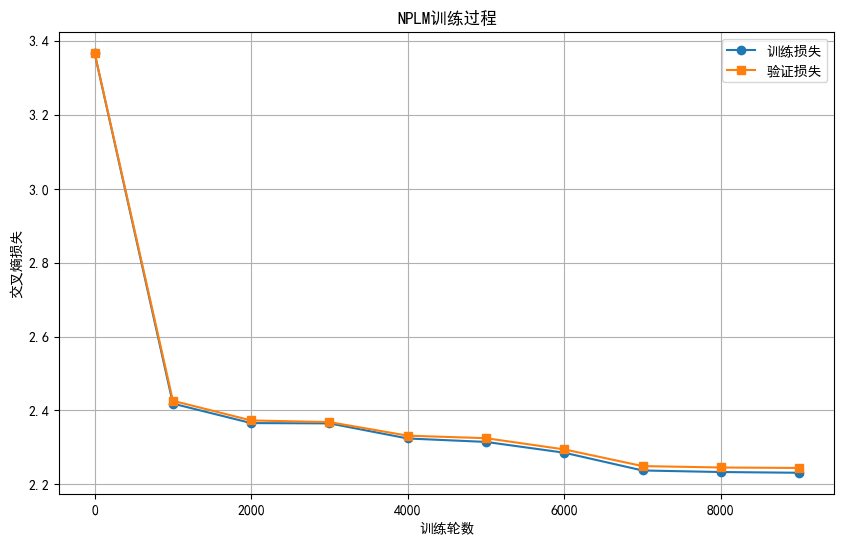

In [148]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_recorded, train_losses, label='训练损失', marker='o')
plt.plot(epochs_recorded, val_losses, label='验证损失', marker='s')
plt.xlabel('训练轮数')
plt.ylabel('交叉熵损失')
plt.title('NPLM训练过程')
plt.legend()
plt.grid(True)
plt.show()

#### 9. 文本生成

使用训练好的模型生成新的名字。

In [149]:
def generate_names(model, itos, stoi, context_size, num_samples=10, max_length=20):
    """生成新的名字"""
    model.eval()
    generated_names = []
    
    with torch.no_grad():
        for _ in range(num_samples):
            context = [0] * context_size  # 以'.'开始
            name = []
            
            for _ in range(max_length):
                # 预测下一个字符
                x = torch.tensor([context])
                logits = model(x)
                probs = F.softmax(logits, dim=1)
                
                # 采样下一个字符
                next_char_idx = torch.multinomial(probs, num_samples=1).item()
                
                # 如果遇到结束符，停止生成
                if next_char_idx == 0:
                    break
                
                # 添加到名字并更新上下文
                char = itos[next_char_idx]
                name.append(char)
                context = context[1:] + [next_char_idx]
            
            generated_names.append(''.join(name))
    
    model.train()
    return generated_names

# 生成新名字
print("=== 生成的名字 ===")
new_names = generate_names(model, itos, stoi, BLOCK_SIZE, num_samples=15)
for i, name in enumerate(new_names, 1):
    print(f"{i:2d}. {name}")

=== 生成的名字 ===
 1. dandeod
 2. luthanna
 3. erogelyronna
 4. shakran
 5. dyren
 6. armana
 7. kayriel
 8. zalairel
 9. havielli
10. ioluwa
11. jaudra
12. gah
13. oron
14. agrie
15. lophio


#### 10. 嵌入向量可视化

可视化学习到的字符嵌入，观察语义相似性。

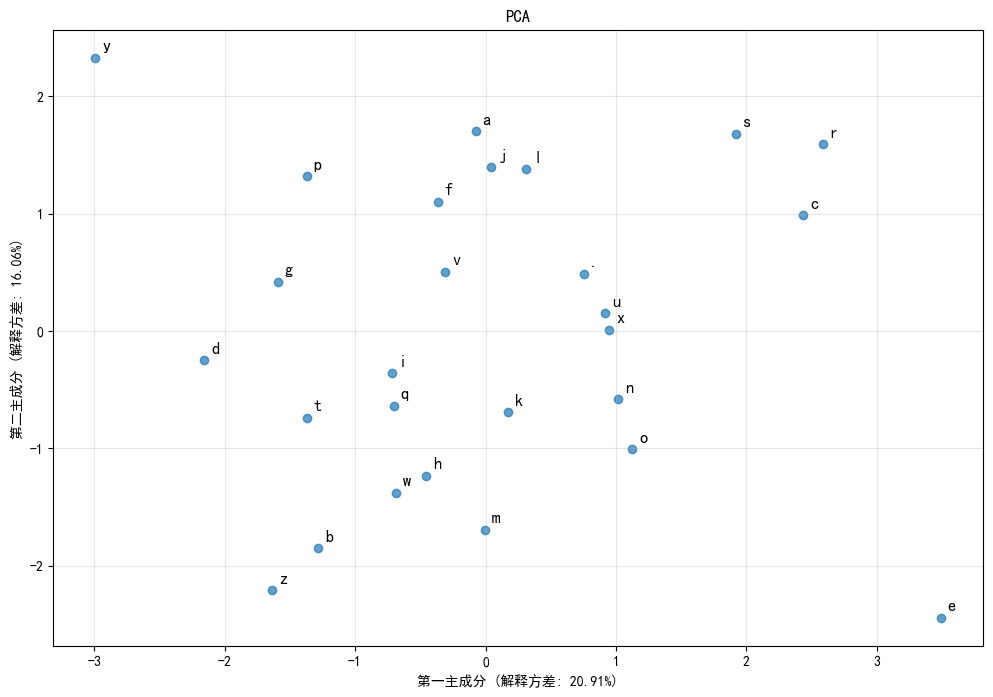

In [150]:
# 获取嵌入矩阵
embeddings = model.embedding.weight.detach()

# 使用PCA降维到2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 绘制嵌入向量
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# 添加字符标签
for i, char in enumerate(chars):
    plt.annotate(char, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.title('PCA')
plt.xlabel(f'第一主成分 (解释方差: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'第二主成分 (解释方差: {pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True, alpha=0.3)
plt.show()


#### 11. 总结

本文件展示神经概率语言模型的核心思想：
1. **词嵌入**: 将离散符号映射到连续向量空间
2. **上下文建模**: 使用固定窗口的历史信息预测下一个词
3. **神经网络**: 通过非线性变换学习复杂的语言模式

这个模型为后续的语言模型发展奠定了重要基础，
包括RNN、LSTM、Transformer等现代架构都受到了NPLM的启发。

**扩展方向:**
- 实现更复杂的网络架构 (如RNN、LSTM)
- 尝试词级别而非字符级别的建模
- 在更大规模的数据集上训练
- 探索不同的采样策略和生成方法